In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
import os
from sklearn.preprocessing import MultiLabelBinarizer
import pickle


# Step 2 Define the Dataset Class (Updated for 15 Labels)

In [36]:
class XRayDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.mlb = MultiLabelBinarizer()
        self.labels = self.mlb.fit_transform(self.dataframe['Finding Labels'].str.split('|'))
        print(f"Number of unique diagnoses: {len(self.mlb.classes_)}")
        assert len(self.mlb.classes_) == 15, "There should be 15 unique diagnoses"

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('L')  # Convert image to grayscale
        labels = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(labels, dtype=torch.float32)


In [35]:
# Load the CSV file
CSV_PATH = 'sample_labels.csv'
df = pd.read_csv(CSV_PATH)

# Inspect unique labels
unique_labels = df['Finding Labels'].str.split('|').explode().unique()
print(f"Unique labels: {unique_labels}")
print(f"Number of unique labels: {len(unique_labels)}")


Unique labels: ['Emphysema' 'Infiltration' 'Pleural_Thickening' 'Pneumothorax'
 'Cardiomegaly' 'No Finding' 'Atelectasis' 'Edema' 'Effusion'
 'Consolidation' 'Mass' 'Nodule' 'Fibrosis' 'Pneumonia' 'Hernia']
Number of unique labels: 15


# Step 3: Load and Prepare the Data

In [37]:
# Define image size
IMG_SIZE = (150, 150)

# Load the CSV file
CSV_PATH = 'sample_labels.csv'
IMAGE_PATH = 'images'

# Load the dataset from CSV
df = pd.read_csv(CSV_PATH)

# Define image transformations
transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])  # Adjust normalization for single channel
])

# Initialize dataset
dataset = XRayDataset(dataframe=df, img_dir=IMAGE_PATH, transform=transform)
num_classes = len(dataset.mlb.classes_)  # Dynamically set the number of classes
print(f"Number of classes: {num_classes}")

# Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Initialize dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


Number of unique diagnoses: 15
Number of classes: 15


# Step 4: Define the CNN Model

In [38]:
from torchvision.models import resnet50

class ModifiedResNet(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet, self).__init__()
        self.resnet = resnet50(weights=None)  # Use weights=None instead of pretrained=False
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)  # 1 input channel
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)

model = ModifiedResNet(num_classes)


# Step 5: Define Loss Function and Optimizer

In [39]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



# Step 6: Train the Model

In [40]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
    
    print(f'Validation Loss: {val_loss/len(val_loader):.4f}')


Epoch [1/10], Loss: 0.2278
Validation Loss: 0.2097
Epoch [2/10], Loss: 0.2199
Validation Loss: 0.2147
Epoch [3/10], Loss: 0.2146
Validation Loss: 0.2079
Epoch [4/10], Loss: 0.2126
Validation Loss: 0.2043
Epoch [5/10], Loss: 0.2120
Validation Loss: 0.2133
Epoch [6/10], Loss: 0.2106
Validation Loss: 0.2060
Epoch [7/10], Loss: 0.2098
Validation Loss: 0.2179
Epoch [8/10], Loss: 0.2098
Validation Loss: 0.2120
Epoch [9/10], Loss: 0.2090
Validation Loss: 0.2090
Epoch [10/10], Loss: 0.2100
Validation Loss: 0.2071


# Step 7: Save the Model and MultiLabelBinarizer

In [41]:
torch.save(model.state_dict(), 'disease_detection_model.pth')

# Save the MultiLabelBinarizer
with open('mlb.pkl', 'wb') as f:
    pickle.dump(dataset.mlb, f)


In [46]:
import numpy as np
import torch
from sklearn.metrics import multilabel_confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Ensure the necessary imports are in place
import pickle

# Load the validation dataset and dataloader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load the model and MultiLabelBinarizer
model = ModifiedResNet(num_classes=15)
model.load_state_dict(torch.load('disease_detection_model.pth'))
model.eval()

with open('mlb.pkl', 'rb') as f:
    mlb = pickle.load(f)

# Generate predictions on the validation set
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        outputs = model(images)
        predicted = (outputs > 0.5).float()
        all_preds.append(predicted.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)


C:\Users\sharm\AppData\Local\Temp\ipykernel_15168\2669831549.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('disease_detection_model.p

# Step 7.5.2: Generate and Visualize Confusion Matrix

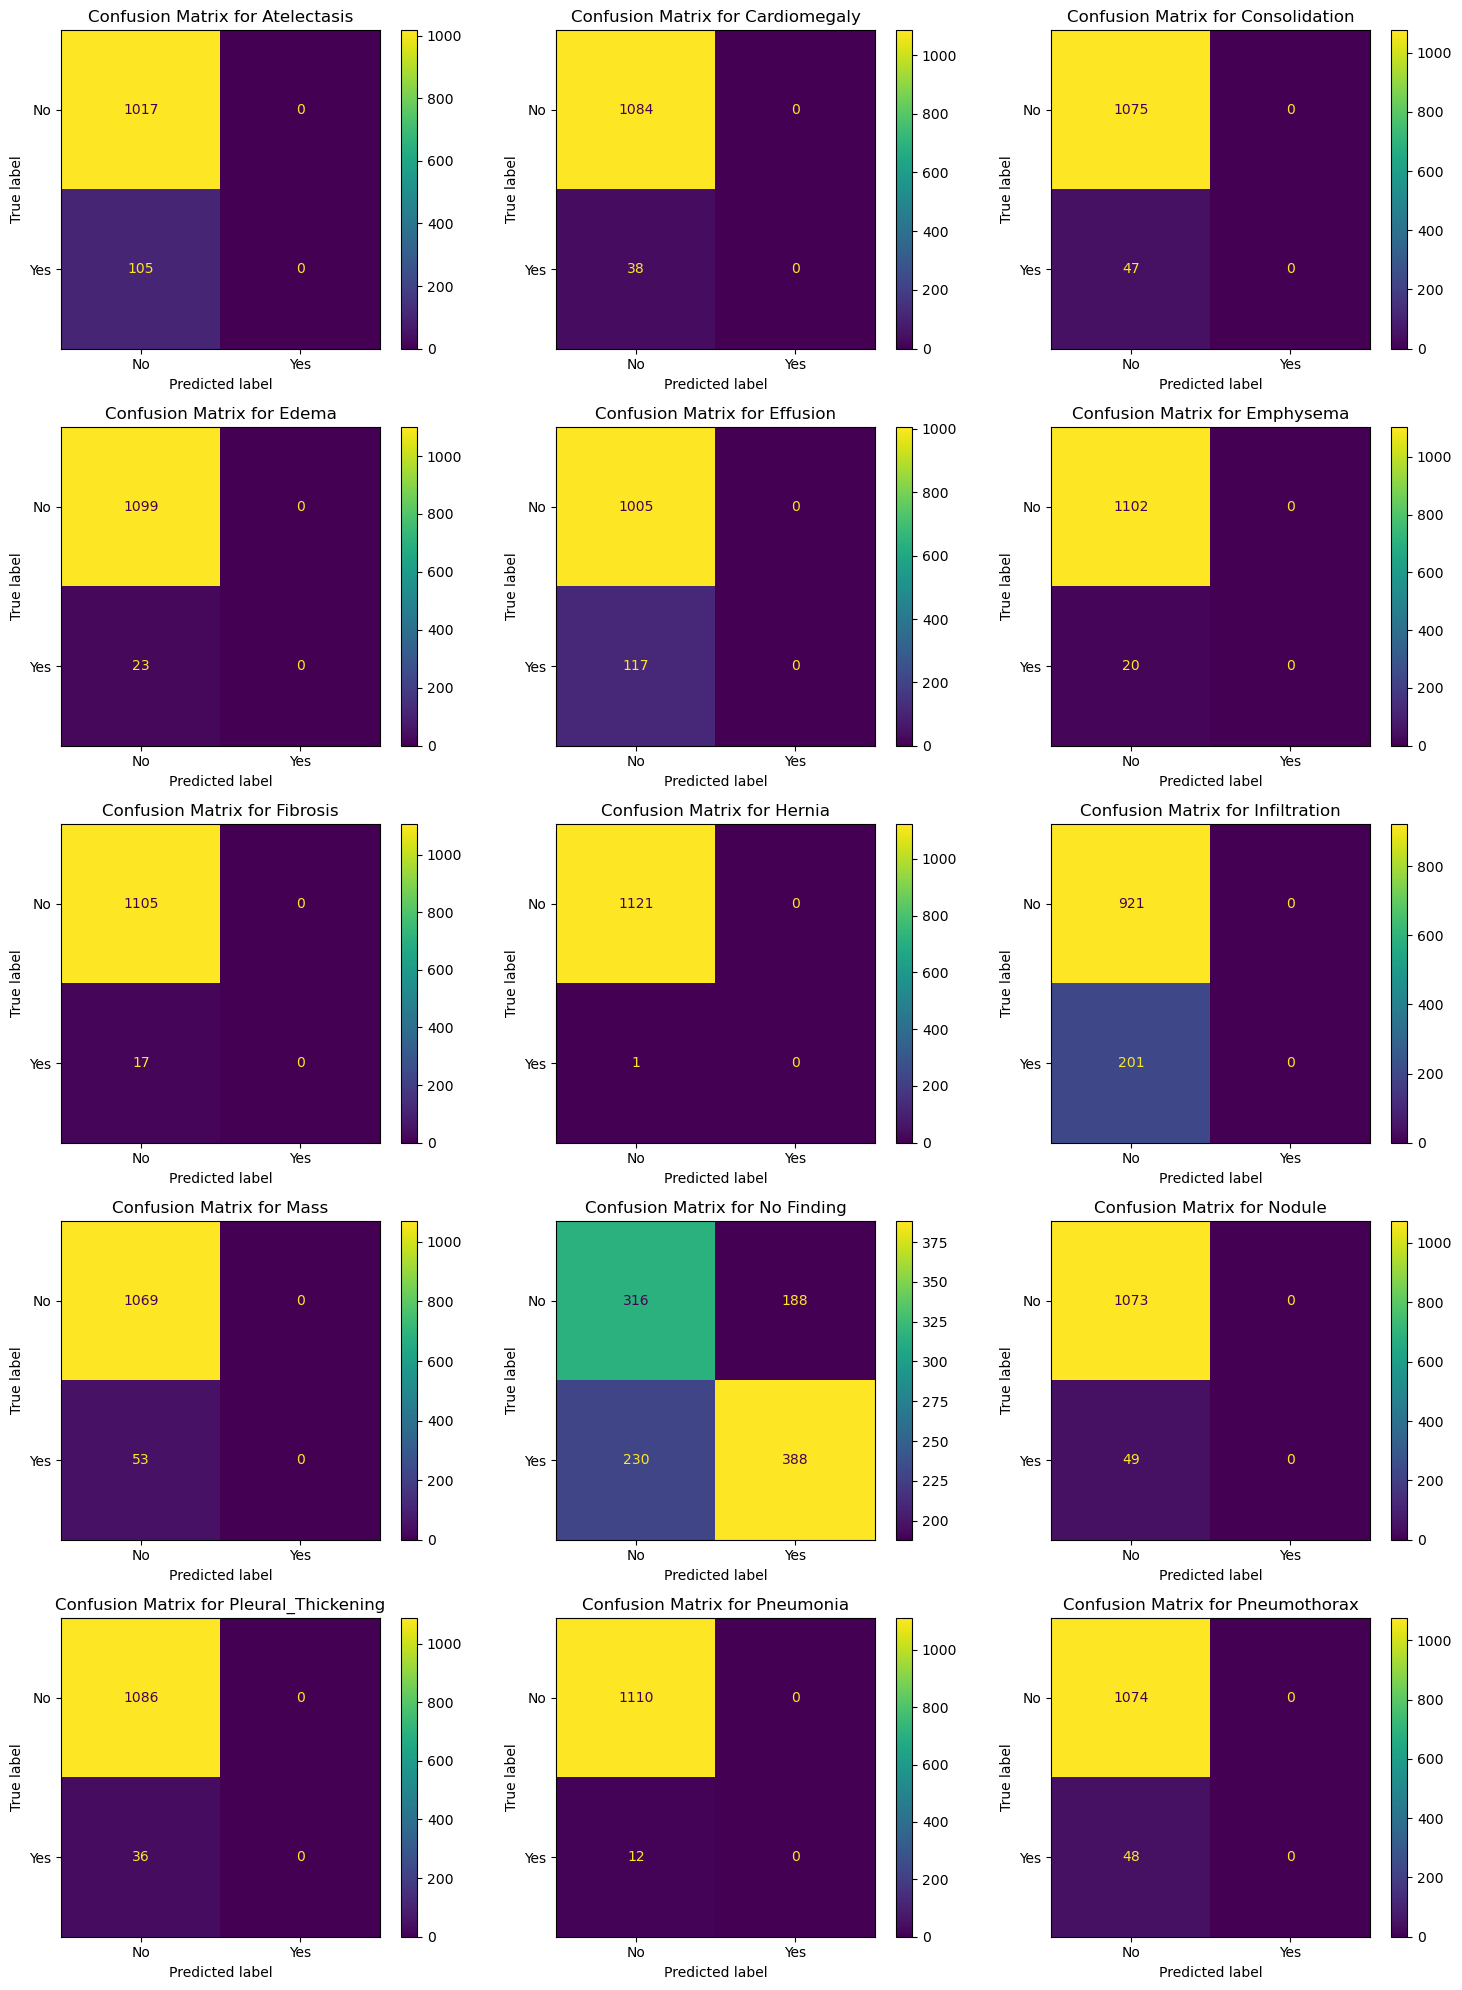

In [47]:
conf_matrix = multilabel_confusion_matrix(all_labels, all_preds)

# Plot confusion matrices for each label
fig, axes = plt.subplots(5, 3, figsize=(15, 20))
axes = axes.ravel()

for i, (cm, label) in enumerate(zip(conf_matrix, mlb.classes_)):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No', 'Yes'])
    disp.plot(ax=axes[i], values_format='d')
    axes[i].set_title(f'Confusion Matrix for {label}')

plt.tight_layout()
plt.show()


# Step 7.5.3: Plot ROC Curves and Calculate AUC Scores

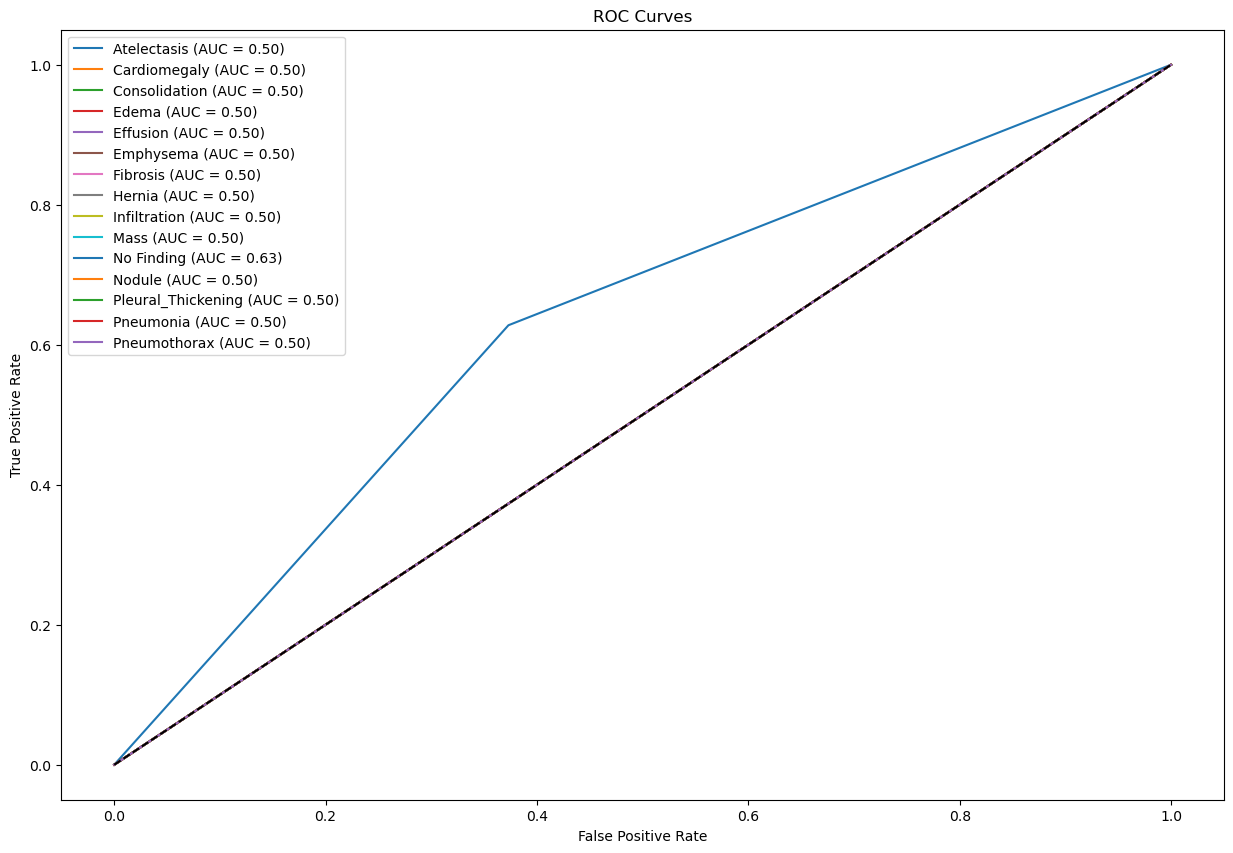

In [50]:
plt.figure(figsize=(15, 10))

for i, label in enumerate(mlb.classes_):
    fpr, tpr, _ = roc_curve(all_labels[:, i], all_preds[:, i])
    auc_score = roc_auc_score(all_labels[:, i], all_preds[:, i])
    plt.plot(fpr, tpr, label=f'{label} (AUC = {auc_score:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc='best')
plt.show()


# Step 7.5.4: Visualize Sample Predictions

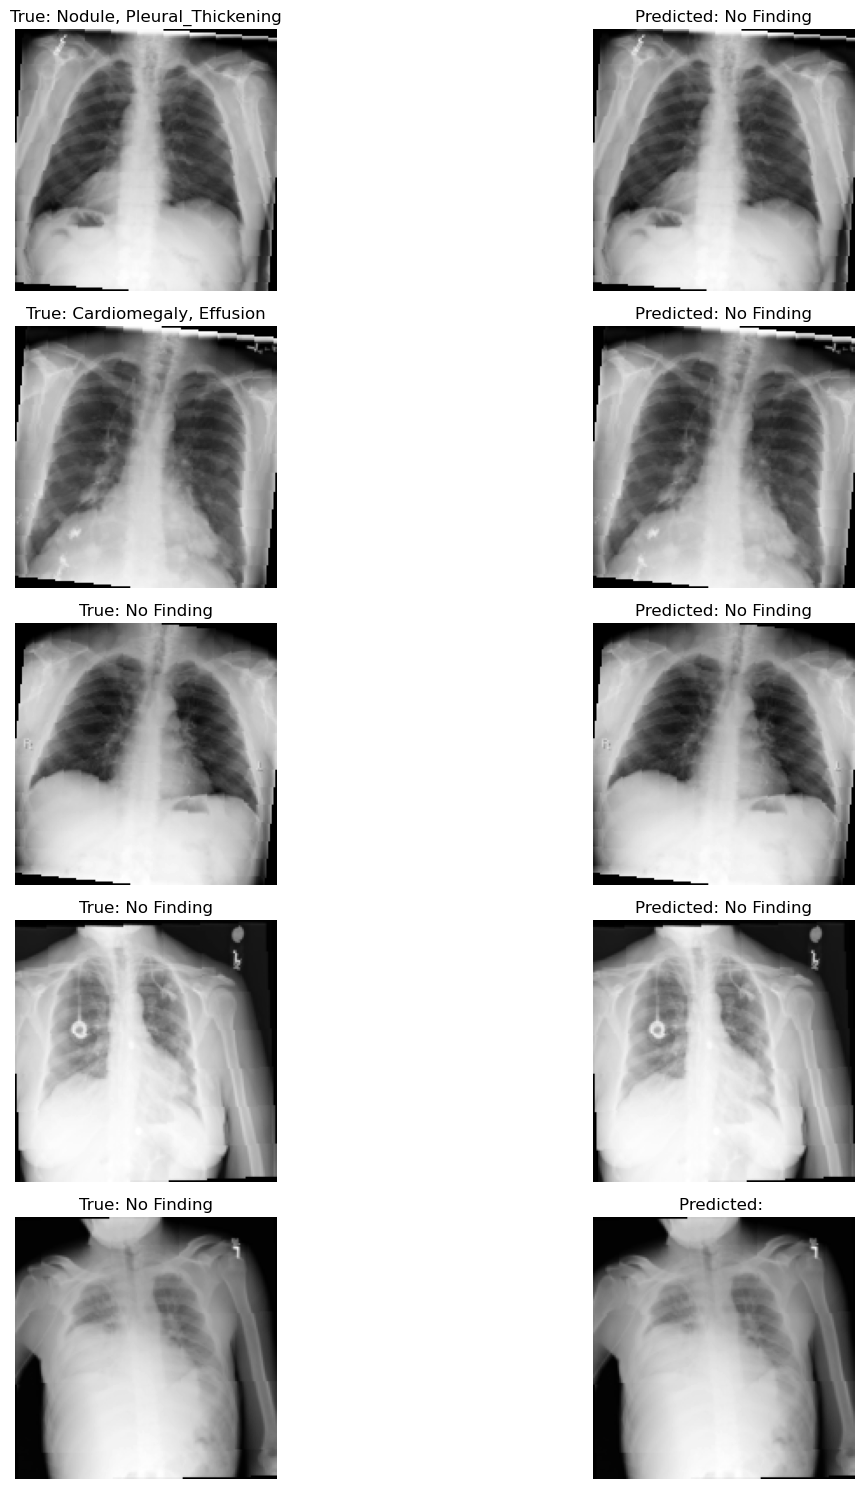

In [51]:
import matplotlib.pyplot as plt

def visualize_predictions(images, labels, predictions, mlb, n=5):
    plt.figure(figsize=(15, 15))
    for i in range(n):
        plt.subplot(n, 2, i * 2 + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        true_labels = mlb.inverse_transform(np.expand_dims(labels[i], axis=0))
        plt.title(f'True: {", ".join(true_labels[0])}')
        plt.axis('off')
        
        plt.subplot(n, 2, i * 2 + 2)
        plt.imshow(images[i].squeeze(), cmap='gray')
        pred_labels = mlb.inverse_transform(np.expand_dims(predictions[i], axis=0))
        plt.title(f'Predicted: {", ".join(pred_labels[0])}')
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualize some predictions
images, labels = next(iter(val_loader))
model.eval()
with torch.no_grad():
    outputs = model(images)
    predictions = (outputs > 0.5).float().cpu().numpy()
    
# Ensure labels are in the correct format
labels = labels.cpu().numpy()

visualize_predictions(images.cpu().numpy(), labels, predictions, mlb)


# Step 8: Set Up Flask Application

In [42]:
import torch
import torch.nn as nn
from torchvision import transforms
from PIL import Image
from flask import Flask, request, render_template_string, send_from_directory
from werkzeug.utils import secure_filename
import pickle
from torchvision.models import resnet50

# Flask app setup
app = Flask(__name__)
app.config['UPLOAD_FOLDER'] = 'uploads/'

# Create the uploads directory if it does not exist
if not os.path.exists(app.config['UPLOAD_FOLDER']):
    os.makedirs(app.config['UPLOAD_FOLDER'])

# Define the CNN model
class ModifiedResNet(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet, self).__init__()
        self.resnet = resnet50(weights=None)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)
        
    def forward(self, x):
        return self.resnet(x)

# Load the model and MultiLabelBinarizer
num_classes = 15  # Number of classes
model = ModifiedResNet(num_classes)
model.load_state_dict(torch.load('disease_detection_model.pth'))
model.eval()

with open('mlb.pkl', 'rb') as f:
    mlb = pickle.load(f)

# Define image transformations for web uploads
web_transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.Grayscale(num_output_channels=1),  # Ensure the image is grayscale
    transforms.ToTensor(),
    transforms.Normalize([0.485], [0.229])
])

@app.route('/')
def upload_file():
    return '''
    <!doctype html>
    <html lang="en">
      <head>
        <title>Upload X-ray Image</title>
      </head>
      <body>
        <h1>Upload X-ray Image for Disease Prediction</h1>
        <form method="post" action="/uploader" enctype="multipart/form-data">
          <input type="file" name="file">
          <input type="submit">
        </form>
      </body>
    </html>
    '''

@app.route('/uploader', methods=['POST'])
def upload_file_handler():
    try:
        if request.method == 'POST':
            f = request.files['file']
            filename = secure_filename(f.filename)
            filepath = os.path.join(app.config['UPLOAD_FOLDER'], filename)
            
            print(f"Saving file to {filepath}")
            f.save(filepath)
            
            # Load and preprocess the image
            image = Image.open(filepath).convert('L')  # Convert to grayscale
            image = web_transform(image)
            image = image.unsqueeze(0)  # Add batch dimension

            # Make prediction
            with torch.no_grad():
                outputs = model(image)
                print("Raw model output:", outputs)  # Print raw model output
                predicted = (outputs > 0.5).float().numpy()

            # Convert prediction to human-readable format
            disease_labels = mlb.classes_
            predicted_diseases = [disease_labels[i] for i in range(len(disease_labels)) if predicted[0][i] == 1]

            return render_template_string('''
            <!doctype html>
            <html lang="en">
              <head>
                <title>Prediction Result</title>
              </head>
              <body>
                <h1>Prediction Result</h1>
                <p>Uploaded Image:</p>
                <img src="/uploads/{{ filename }}" alt="Uploaded Image" style="width:300px;">
                <h2>Predicted Diseases:</h2>
                <ul>
                  {% for disease in diseases %}
                  <li>{{ disease }}</li>
                  {% endfor %}
                </ul>
                <a href="/">Upload another image</a>
              </body>
            </html>
            ''', filename=filename, diseases=predicted_diseases)
    except Exception as e:
        print(f"Error occurred: {e}")
        return "An error occurred during the prediction process."

@app.route('/uploads/<filename>')
def send_file(filename):
    return send_from_directory(app.config['UPLOAD_FOLDER'], filename)

if __name__ == '__main__':
    app.run(debug=True)


 * Serving Flask app '__main__'
 * Debug mode: on


C:\Users\sharm\AppData\Local\Temp\ipykernel_15168\1632101166.py:32: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('disease_detection_model.p

SystemExit: 1

c:\Users\sharm\anaconda3\envs\xray-disease-detection\Lib\site-packages\IPython\core\interactiveshell.py:3585: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


# Step 10 Click on the Url http://127.0.0.1:5000

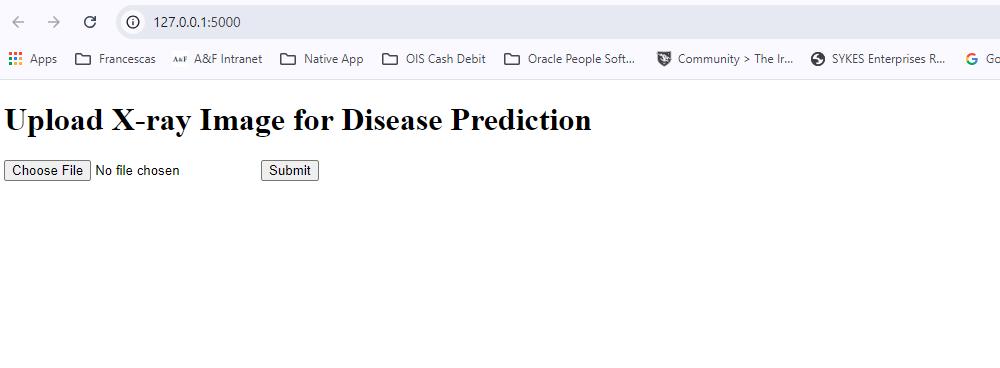

# Step 10 After uploading xray, modal predicted disease as Effusion

Upload the Xray 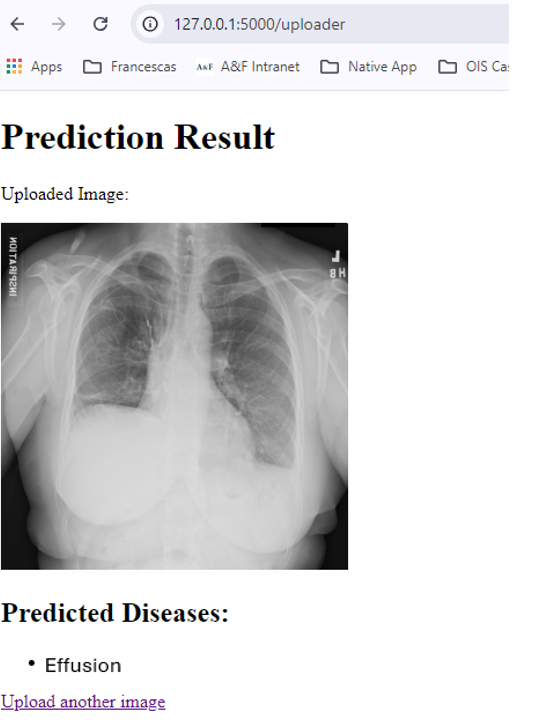